<a href="https://colab.research.google.com/github/wanloc04/Ball-Mapper-for-Iris-and-Diabetes/blob/main/Ball_Mapper_for_Iris_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

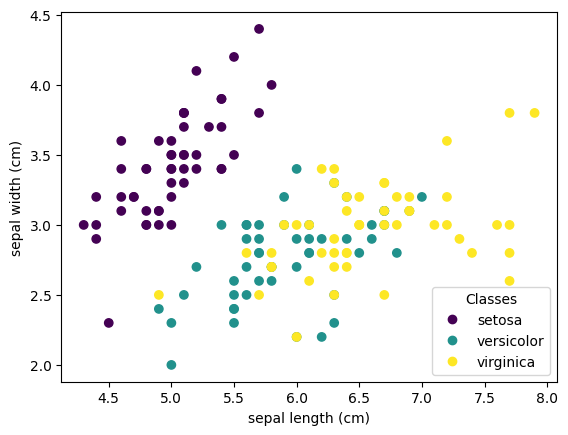

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

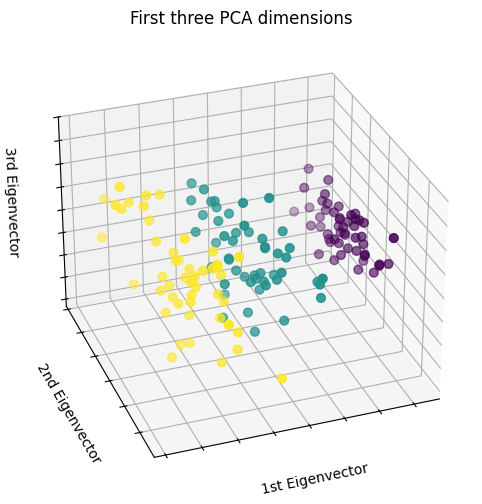

In [ ]:
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=iris.target,
    s=40,
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st Eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd Eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd Eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

#Theo lớp

Các đỉnh của đồ thị (node indices): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Các cạnh của đồ thị (edge pairs): [(0, 4), (0, 8), (1, 6), (1, 5), (2, 7), (2, 10), (2, 9), (3, 9), (3, 10), (3, 7), (3, 6), (3, 5), (5, 6), (6, 9), (7, 10), (7, 9), (9, 10)]
Số lượng đỉnh: 11
Số lượng cạnh: 17


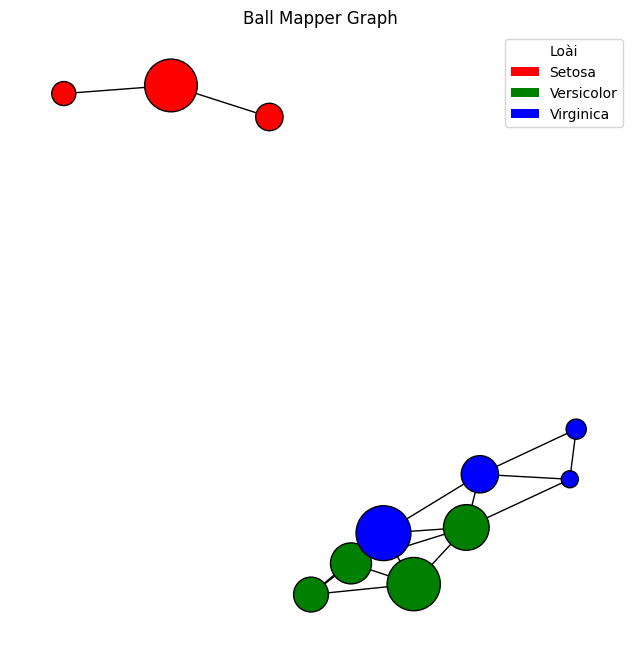

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from collections import defaultdict
from matplotlib.patches import Patch


def max_min_epsilon_net(X, epsilon):
    centers = [X[0]]
    indices = [0]
    while True:
        dists = np.array([min(np.linalg.norm(x - c) for c in centers) for x in X])
        max_dist = np.max(dists)
        if max_dist <= epsilon:
            break
        next_idx = np.argmax(dists)
        centers.append(X[next_idx])
        indices.append(next_idx)
    return indices

def build_ball_mapper_graph(X, center_indices, epsilon):
    G = nx.Graph()
    n = len(center_indices)
    for i in range(n):
        G.add_node(i)

    point_to_balls = defaultdict(list)
    for i, x in enumerate(X):
        for j, c_idx in enumerate(center_indices):
            if np.linalg.norm(x - X[c_idx]) <= epsilon:
                point_to_balls[i].append(j)

    for balls in point_to_balls.values():
        for i in range(len(balls)):
            for j in range(i + 1, len(balls)):
                G.add_edge(balls[i], balls[j])

    return G, point_to_balls

def compute_discrete_class_colors(y, center_indices, point_to_balls):
    color_map = {0: 'red', 1: 'green', 2: 'blue'}
    node_colors = []
    for j in range(len(center_indices)):
        indices = [i for i, balls in point_to_balls.items() if j in balls]
        if indices:
            counts = np.bincount(y[indices], minlength=3)
            dominant_class = np.argmax(counts)
        else:
            dominant_class = 0
        node_colors.append(color_map[dominant_class])
    return node_colors


iris = load_iris()
X = iris.data
y = iris.target

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

epsilon = 0.35

center_indices = max_min_epsilon_net(X_scaled, epsilon)
G, point_to_balls = build_ball_mapper_graph(X_scaled, center_indices, epsilon)
colors = compute_discrete_class_colors(y, center_indices, point_to_balls)

# In ra danh sách đỉnh và cạnh của đồ thị
print("Các đỉnh của đồ thị (node indices):", G.nodes())
print("Các cạnh của đồ thị (edge pairs):", G.edges())
print("Số lượng đỉnh:", G.number_of_nodes())
print("Số lượng cạnh:", G.number_of_edges())

node_sizes = []
for node in range(len(center_indices)):
    num_points_in_ball = sum(1 for points in point_to_balls.values() if node in points)
    node_sizes.append(num_points_in_ball * 30)

fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    G, ax=ax,
    with_labels=False,
    node_size=node_sizes,
    node_color=colors,
    edgecolors='black'
)

legend_elements = [
    Patch(facecolor='red', label='Setosa'),
    Patch(facecolor='green', label='Versicolor'),
    Patch(facecolor='blue', label='Virginica')
]
ax.legend(handles=legend_elements, title="Loài", loc='upper right')

plt.title("Ball Mapper Graph")
plt.show()

In [ ]:
def print_dominant_class_ratios(y, center_indices, point_to_balls):
    for j in range(len(center_indices)):
        indices = [i for i, balls in point_to_balls.items() if j in balls]
        if indices:
            counts = np.bincount(y[indices], minlength=3)
            dominant_class = np.argmax(counts)
            ratio = counts[dominant_class] / sum(counts)
            print(f"Node {j}: {ratio:.2%} là lớp chiếm ưu thế ({iris.target_names[dominant_class]})")
        else:
            print(f"Node {j}: Không chứa điểm nào")

def compute_ball_mapper_accuracy(y, center_indices, point_to_balls):
    correct = 0
    total = 0
    for j in range(len(center_indices)):
        indices = [i for i, balls in point_to_balls.items() if j in balls]
        if not indices:
            continue
        counts = np.bincount(y[indices], minlength=3)
        dominant_class = np.argmax(counts)
        correct += counts[dominant_class]
        total += sum(counts)
    accuracy = correct / total
    return accuracy


In [ ]:
print_dominant_class_ratios(y, center_indices, point_to_balls)
acc = compute_ball_mapper_accuracy(y, center_indices, point_to_balls)
acc

In [ ]:
from sklearn.metrics import silhouette_samples
import numpy as np

def get_SC_ballmapper(data, point_to_balls, norm=0, k=3):
    ele_list = []
    cluster_labels = []

    for ball_id in set(b for balls in point_to_balls.values() for b in balls):
        for i, balls in point_to_balls.items():
            if ball_id in balls:
                ele_list.append(i)
                cluster_labels.append(ball_id)

    if len(set(cluster_labels)) < 2:
        return 0

    data_points = data[ele_list]
    labels = np.array(cluster_labels)

    try:
        score = silhouette_samples(data_points, labels)
        sc_raw = np.mean(score)
    except:
        sc_raw = -1

    sc_rounded = round(sc_raw, k)

    if norm == 0:
        return sc_rounded
    elif norm == 1:
        sc_norm = (sc_rounded + 1) / 2
        return round(sc_norm, k)
    else:
        raise ValueError("norm chỉ nhận 0 hoặc 1.")


In [ ]:
sc = get_SC_ballmapper(X_scaled, point_to_balls, norm=0)
sc_norm = get_SC_ballmapper(X_scaled, point_to_balls, norm=1)

print(f"Silhouette Coefficient: {sc}")
print(f"SC normalized (0-1): {sc_norm}")

Silhouette Coefficient: 0.297
SC normalized (0-1): 0.648


# Theo từng thuộc tính

Nhập bán kính ε: 0.35
Tô màu theo thuộc tính thứ: 2


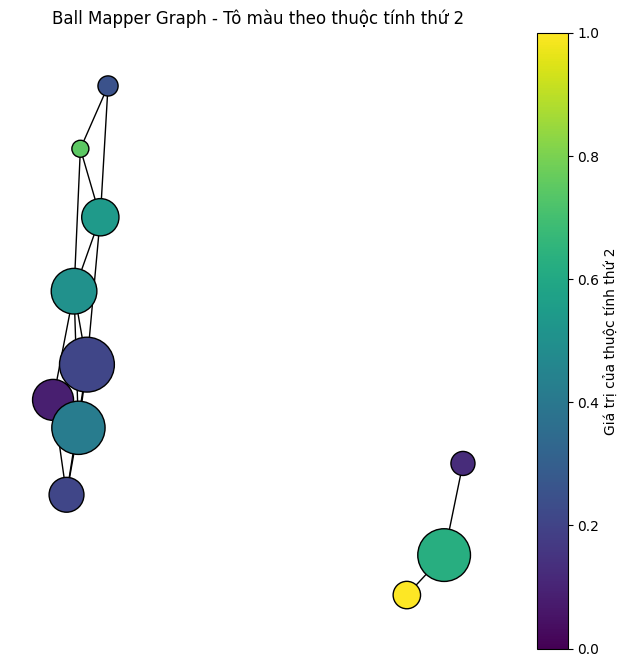

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from collections import defaultdict

def max_min_epsilon_net(X, epsilon):
    centers = [X[0]]
    indices = [0]
    while True:
        dists = np.array([min(np.linalg.norm(x - c) for c in centers) for x in X])
        max_dist = np.max(dists)
        if max_dist <= epsilon:
            break
        next_idx = np.argmax(dists)
        centers.append(X[next_idx])
        indices.append(next_idx)
    return indices

def build_ball_mapper_graph(X, center_indices, epsilon):
    G = nx.Graph()
    n = len(center_indices)
    for i in range(n):
        G.add_node(i)

    point_to_balls = defaultdict(list)
    for i, x in enumerate(X):
        for j, c_idx in enumerate(center_indices):
            if np.linalg.norm(x - X[c_idx]) <= epsilon:
                point_to_balls[i].append(j)

    for balls in point_to_balls.values():
        for i in range(len(balls)):
            for j in range(i + 1, len(balls)):
                G.add_edge(balls[i], balls[j])

    return G, point_to_balls

def compute_ball_colors_by_feature(X, center_indices, feature_index):
    feature_values = X[:, feature_index]
    norm = plt.Normalize(vmin=np.min(feature_values), vmax=np.max(feature_values))
    colors = plt.cm.viridis(norm(feature_values[center_indices]))
    return colors, norm

# Load dữ liệu Iris
iris = load_iris()
X = iris.data
y = iris.target

# Chuẩn hóa
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Nhập epsilon và chỉ số biến
epsilon = float(input("Nhập bán kính ε: "))
feature_index = int(input(f"Tô màu theo thuộc tính thứ: ")) - 1

center_indices = max_min_epsilon_net(X_scaled, epsilon)
colors, norm = compute_ball_colors_by_feature(X_scaled, center_indices, feature_index)

# Tạo đồ thị Ball Mapper
G, point_to_balls = build_ball_mapper_graph(X_scaled, center_indices, epsilon)

# Tính kích thước của các đỉnh dựa trên số điểm trong quả cầu
node_sizes = []
for node in range(len(center_indices)):
    num_points_in_ball = sum(1 for points in point_to_balls.values() if node in points)
    node_sizes.append(num_points_in_ball * 30)  # Giảm hệ số từ 50 xuống 30 để bóng nhỏ hơn

# Vẽ đồ thị
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    G, ax=ax,
    with_labels=False,
    node_size=node_sizes,
    node_color=colors,
    font_color='black',
    font_weight='bold',
    edgecolors='black'
)

# Thêm chú thích cho màu sắc
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label=f"Giá trị của thuộc tính thứ {feature_index + 1}")

plt.title(f"Ball Mapper Graph - Tô màu theo thuộc tính thứ {feature_index + 1}")
plt.show()
